In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import logging, sys
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
logger = logging.getLogger('')
sh = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(levelname)s %(message)s', datefmt='%a, %d %b %Y %H:%M:%S')
sh.setFormatter(formatter)
logger.addHandler(sh)
from frontiers_analysis import load_tissue

In [2]:
import pandas as pd
import gc
gc.collect()
tissue="Uterus"
try:
    df = pd.read_csv(f"The_single_cell_transcriptome_as_a_component_system/MouseCellAtlas/mca/mainTable_{tissue}.csv", index_col=0)
    M = df.sum(0)
    f = df.divide(M,1).mean(1)
    O = df.apply(lambda x: (x>0).sum(), 1)
except:
    print("Loading with pickle")
    data = load_tissue(tissue)
    M = data["M"]
    f = data["f"]
    O = data["O"]

In [3]:
#f = np.genfromtxt("The_single_cell_transcriptome_as_a_component_system/MouseCellAtlas/A_gtex.dat", delimiter=",")[1:,1]
#M = np.random.normal(1500, 100, size=5000)

In [4]:
class method():
    def __init__(self, name=" ", color="gray"):
        self.table = []
        self.f = None
        self.h = []
        self.M = None
        self.O = None
        self.__name__ = name
        self.color_ = color
        self.name_ = name
        
        self.hmean = None
        self.hvar = None
        self.cnt = None
        
    def get_pvals(self):
        return f/f.sum()
    
    def get_h(self):
        return self.h
    
    def get_f(self):
        f = np.array(self.table).T.mean(1)
        return np.sort(f/f.sum())[::-1]
    
    def get_O(self):
        if self.O is None:
            self.O =list(map(lambda x: len(x[x>0])/len(x), np.array(self.table).T))
        return self.O
    
    @property
    def matrix(self):
        return np.array(self.table)

    def sample(self, m) -> None:
        c = np.random.multinomial(m, self.get_pvals())
        self.table.append(c)
        self.h.append((c>0).sum())
    
    def run(self):
        logger.info(f"running {self.name_}")
        for m in M:
            self.sample(m)
    
    def __repr__(self):
        return self.__name__
    
class mazzolini(method):
    def __init__(self):
        super().__init__("mazzolini", "orange")
        
class mazzolini_pc(method):
    def __init__(self, pc=0.3):
        super().__init__("mazzolini*P_c", "blue")
        self.mu = pc
    
    def sample(self, m) -> None:
        c = np.random.multinomial(m, self.get_pvals())
        c[np.random.choice(len(c), round(0.3*len(c)))] = 0
        self.table.append(c)
        self.h.append((c>0).sum())
    
class mazzolini_broad(method):
    def __init__(self, M = 100000):
        super().__init__("mazzolini_broad", "green")
        self.p = None
        self.M = M
    
    def get_pvals(self):
        raise NotImplementedError("use get_pvals(m)")
        
    def get_pvals(self, m):
        if m > self.M:
            raise ValueError(f"{self.M} is a too low Mtilde use at least {m}")
        if self.p is None:
            self.p = [np.random.poisson(round(fi * self.M), 1)[0] for fi in super().get_pvals()]
            self.p = self.p/np.sum(self.p)
        return self.p
    
    def sample(self, m) -> None:
        try:
            c = np.random.multinomial(m, self.get_pvals(m))
            self.table.append(c)
            self.h.append((c>0).sum())
        except:
            import sys
            print(sys.exc_info())
            print(np.sum(self.get_pvals()))
            print(np.isnan(self.get_pvals()).any())
            print((self.get_pvals(m)>=1).any())
            print((self.get_pvals(m)<0).any())

In [5]:
M_tilde = 20000

In [6]:
#mazz = mazzolini()
#mazz_pc = mazzolini_pc()
#mazz_broad = mazzolini_broad()
#with mp.Pool(6) as pool:
#    for method in [mazz, mazz_pc, mazz_broad]:
#        pool.apply_async(method.run(), args=())

In [7]:
mazz = mazzolini()
#mazz_pc = mazzolini_pc()
mazz_broad = mazzolini_broad(M=M_tilde)
models = [mazz, mazz_broad]
for method in models:
    print(method)
    method.run()

mazzolini
mazzolini_broad


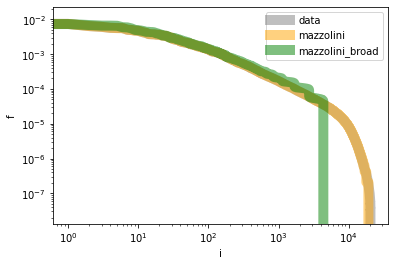

In [8]:
plt.plot(np.sort(f/f.sum())[::-1], lw=10, c="gray", alpha=0.5, label="data")
for model in models:
    plt.plot(model.get_f(), lw=10, alpha=0.5, label=model.name_, c=model.color_)

plt.xlabel("i")
plt.ylabel("f")

plt.xscale("log")
plt.yscale("log")

plt.legend()

mazzolini
mazzolini_broad


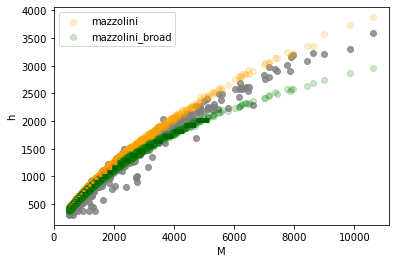

In [9]:
bins = np.logspace(np.log10(M.min()), np.log10(M.max()), 35)
#bins = np.linspace(M.min(), M.max(), 35)
    
plt.scatter(M, df.apply(lambda x: (x>0).sum(), 0), c="gray", alpha=0.8)
means, edges, _ = binned_statistic(M, model.get_h(), bins=bins)
var, edges, _ = binned_statistic(M, model.get_h(), statistic="std", bins=bins)
cnt, edges, _ = binned_statistic(M, model.get_h(), statistic="count", bins=bins)
var = var*var
mask = cnt > 10
means = means[mask]
var = var[mask]
l_edges = (edges[:-1])[mask]
r_edges = (edges[1:])[mask]
plt.hlines(means, l_edges, r_edges, lw=5, color="dark"+model.color_, ls="--")

for model in models:
    print(model.name_)
    means, edges, _ = binned_statistic(M, model.get_h(), bins=bins)
    var, edges, _ = binned_statistic(M, model.get_h(), statistic="std", bins=bins)
    cnt, edges, _ = binned_statistic(M, model.get_h(), statistic="count", bins=bins)
    var = var*var
    mask = cnt > 100
    means = means[mask]
    var = var[mask]
    l_edges = (edges[:-1])[mask]
    r_edges = (edges[1:])[mask]
    
    model.hmean = means
    model.hvar = var
    model.cnt = cnt

    plt.hlines(means, l_edges, r_edges, lw=5, color="dark"+model.color_, ls="--")

    plt.scatter(M, model.get_h(), alpha=0.2, c=model.color_, label=model.name_)

plt.xlabel("M")
plt.ylabel("h")

plt.legend()

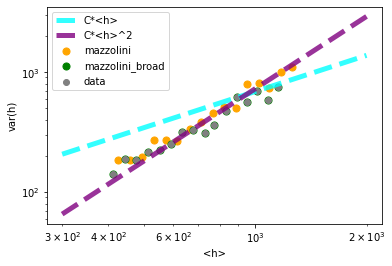

In [10]:
x = np.logspace(np.log10(300),np.log10(2000))

for model in models:
    plt.scatter(model.hmean, model.hvar, s=50, label=model.name_, c=model.color_)

plt.scatter(means, var, label="data", c="gray")
    
popt, pcov= curve_fit(lambda x, C: C*x, models[0].hmean, models[0].hvar)
plt.plot(x, popt[0]*x, lw=5, ls="--", c="cyan", alpha=0.8, label="C*<h>")

popt, pcov= curve_fit(lambda x, C: C*x*x, models[0].hmean, models[0].hvar)
plt.plot(x, popt[0]*x**2, lw=5, ls="--", c="purple", alpha=0.8, label ="C*<h>^2")
    
plt.xlabel("<h>")
plt.ylabel("var(h)")

plt.xscale("log")
plt.yscale("log")

plt.legend()

#plt.ylim(1e2,1e3)

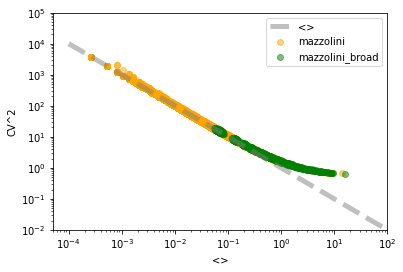

In [11]:
for model in models:
    means = np.mean(model.table,0)
    mean = means[means>0]
    var = np.var(model.table,0)
    cv2 = var[means>0]/mean/mean
    plt.scatter(mean,cv2, alpha=0.5, label=model.name_,c=model.color_)

x = np.linspace(1e-4,1e2,10)
plt.plot(x,1/x, alpha=0.5, label="<>",c="gray", ls="--", lw=5)

    
plt.xscale("log")
plt.yscale("log")

plt.xlabel("<>")
plt.ylabel("CV^2")

plt.ylim(1e-2,1e5)
plt.xlim(5e-5,1e2)


plt.legend()

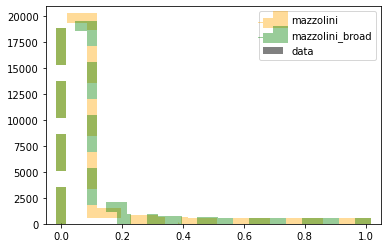

In [12]:
for model in models:
    plt.hist(model.get_O(), lw=10, ls="--", histtype="step", label=model.name_, color=model.color_, alpha=0.4)
    
plt.hist(O/O.sum(), color="gray", label="data")
plt.legend()

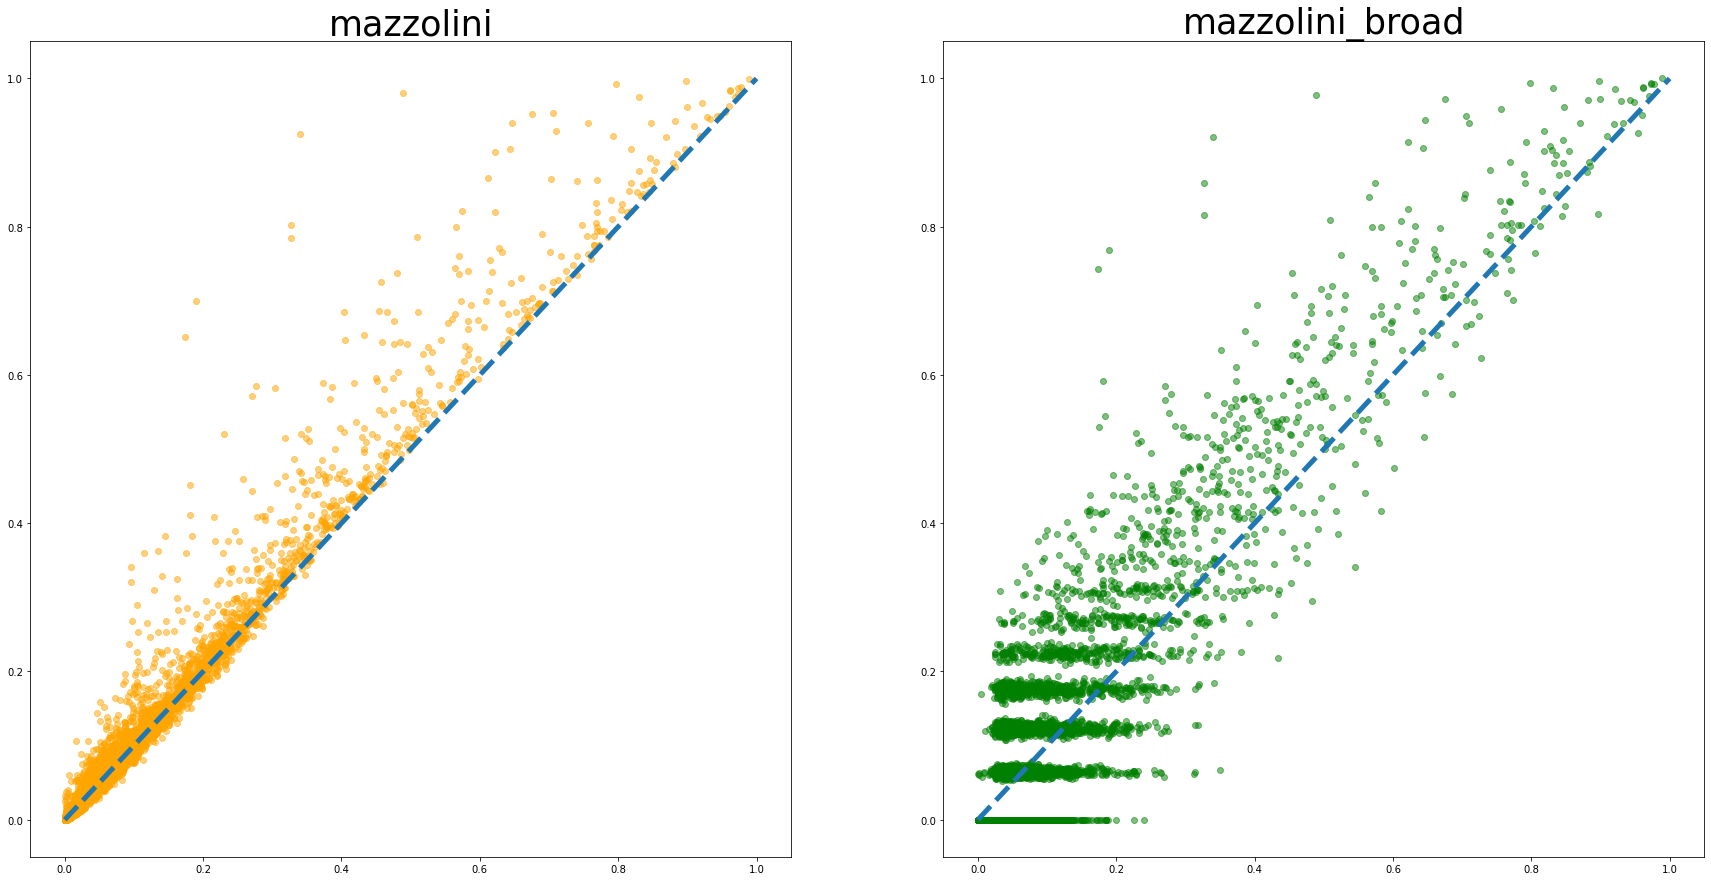

In [13]:
fig, axs = plt.subplots(1, len(models), figsize=(30, 15))

for model, ax in zip(models, axs):
    ax.scatter(O/df.shape[1], model.get_O(), label=model.name_, color=model.color_, alpha=0.5)
    ax.plot([0,1], [0,1], lw=5, ls="--")
    ax.set_title(model.name_, fontsize=35)
    

In [14]:
df_data = pd.DataFrame(data=f, columns=["f"])
df_data.insert(1,"O_real",O/O.max())
df_data.insert(1,"O_pred",models[-1].get_O())
df_data.to_csv(f"fOrealOpred_M{M_tilde}_{tissue}.csv", index=True)

df_data = pd.DataFrame(data=f, columns=["f"])
df_data.insert(1,"O_real",O/O.max())
df_data.insert(1,"O_pred",models[0].get_O())
df_data.to_csv(f"fOrealOpred_{tissue}.csv", index=True)

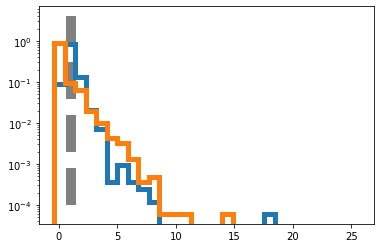

In [15]:
nbins=30
binmax = 25
binmin = 1e-10
rang = binmax-binmin
bins = np.linspace(binmin-0.5*rang/nbins, binmax+0.5*nbins/rang, nbins)
plt.hist(models[0].get_O()/O*df.shape[1], histtype="step", bins=bins, lw=5, density=True)
plt.hist(models[-1].get_O()/O*df.shape[1], histtype="step", bins=bins, lw=5, density=True)
plt.vlines(1,1e-4,4e0, lw=10, color="gray", ls="--")
plt.yscale("log")

In [16]:
pd.DataFrame(data=np.array(models[0].table).T, columns = df.columns).to_csv(f"The_single_cell_transcriptome_as_a_component_system/MouseCellAtlas/mca/mainTable_{tissue}_mazzolini.csv")

In [17]:
#list(map(print,f[(models[0].get_O()/O*df.shape[1]<1) & (models[0].get_O()/O*df.shape[1]>0)].sort_values(ascending=False)[:100].index))

In [18]:
sparsities = []
for sample in range(10):
    model = mazzolini()
    model.run()
    E = (np.array(model.table)>0).sum()
    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
    sparsities.append(1-float(E)/N)

In [19]:
sparsities_pois_5 = []
for sample in range(25):
    model = mazzolini_broad(M=500000)
    model.run()
    E = (np.array(model.table)>0).sum().sum()
    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
    sparsities_pois_5.append(1-float(E)/N)
    
sparsities_pois = []
for sample in range(25):
    model = mazzolini_broad(M=M_tilde)
    model.run()
    E = (np.array(model.table)>0).sum().sum()
    N = np.array(model.table).shape[0] * np.array(model.table).shape[1]
    sparsities_pois.append(1-float(E)/N)

In [20]:
E = (df>0).sum().sum()
N = df.shape[0] * df.shape[1]
data_sparsity=[1-E/N]

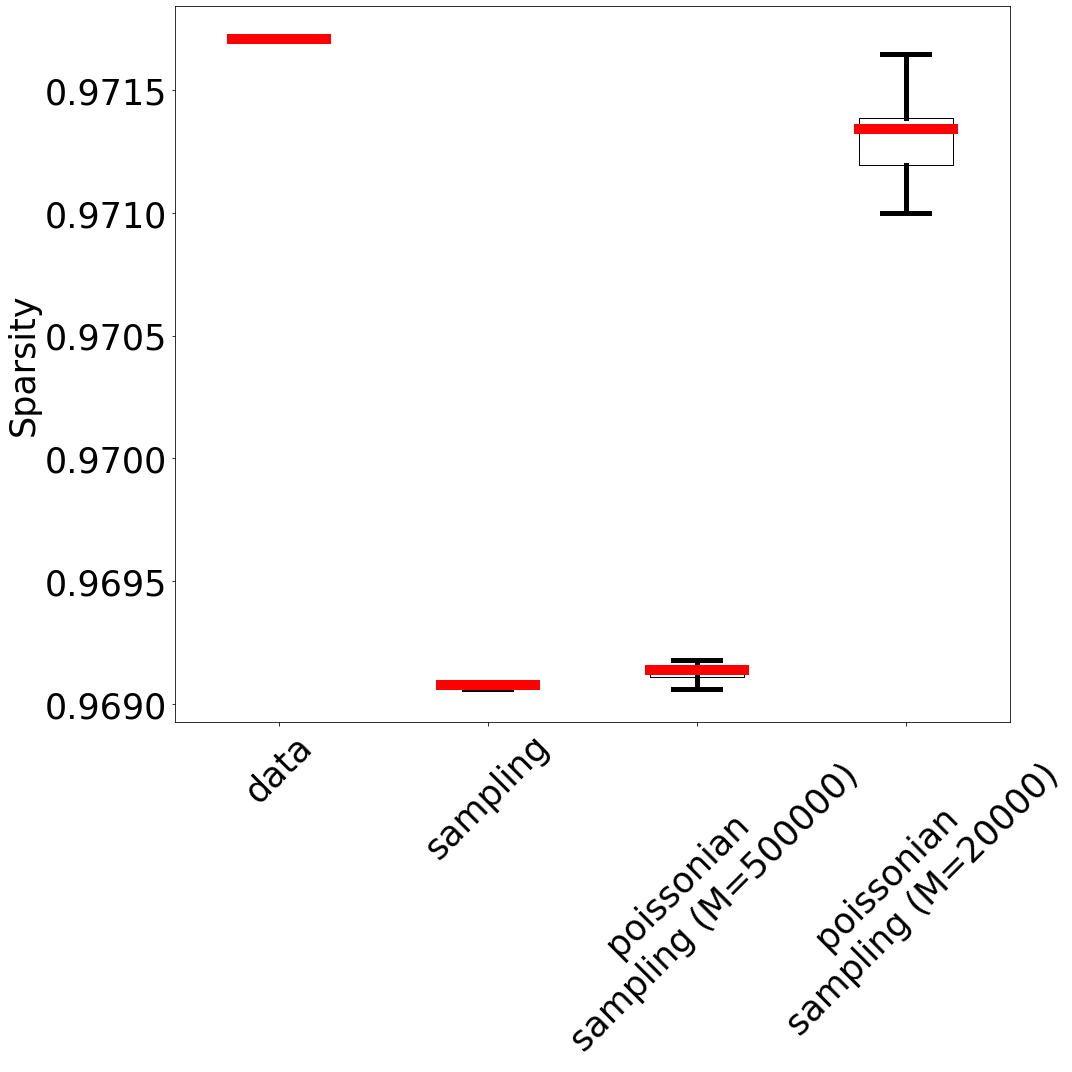

In [21]:
fig = plt.figure(figsize=(15,15))

plt.boxplot([data_sparsity,sparsities,sparsities_pois_5, sparsities_pois], labels=["data", "sampling", "poissonian \n sampling (M=500000)", f"poissonian \n sampling (M={M_tilde})"], medianprops={"lw":10, "color":"red"}, whiskerprops={"lw":5}, capprops={"lw":5})
#plt.boxplot([data_sparsity,sparsities], labels=["data", "sampling"], medianprops={"lw":15, "color":"red"}, whiskerprops={"lw":5}, capprops={"lw":5})

plt.ylabel("Sparsity", fontsize=35)
plt.xticks(rotation=45)
plt.tick_params(labelsize=35)
plt.tight_layout()
plt.show()
fig.savefig(f"Sparsity_box_{tissue}.pdf")